In [11]:
using DataFrames
using CSV
using Plots
using Dates
using Statistics
plot(xs,μs,grid=false,ribbon=σs,fillalpha=.5)using Distances
gr();

In [6]:
@show haversine((42.3502, -71.1046), (42.0144, -71.9937), 6356) # wrong
@show haversine((-71.1046, 42.3502), (-71.9937, 42.0144), 6356); # right
# use haversine with lon, lat; lon, lat.

haversine((42.3502, -71.1046), (42.0144, -71.9937), 6356) = 99.33238609118257
haversine((-71.1046, 42.3502), (-71.9937, 42.0144), 6356) = 82.03168563530122


82.03168563530122

In [3]:
pandora = CSV.read("pandora_timed_2019_11_16.csv"; copycols=false); # loc: -71.1046, +42.3502 lon,lat
tropomi = CSV.read("total_output_2019_11_22_july_only.csv"; copycols=false);

In [4]:
@show first(pandora, 5); # units: DU
@show first(tropomi, 5); # units: moles/m^2
# moles/m^2 = 6.022e19 molecules/cm^2
# tropomi_no2 = convert(Array{Float32, 1}, tropomi[!, :no2]) .* 6.022e19;
# 1 DU = 0.4462 mmol/m^2 = 2.6871e16 molecules/cm^2
# pandora_no2 = convert(Array{Float32, 1}, pandora[!, 7]) .* 2.6871e16;

first(pandora, 5) = 5×9 DataFrame
│ Row │ Year  │ Month │ Day   │ Hour  │ Minute │ timestamp  │ VCD(DU) │ UNCERTAINTY(DU) │ SZA     │
│     │ Int64 │ Int64 │ Int64 │ Int64 │ Int64  │ Int64      │ Float64 │ Float64         │ Float64 │
├─────┼───────┼───────┼───────┼───────┼────────┼────────────┼─────────┼─────────────────┼─────────┤
│ 1   │ 2019  │ 6     │ 27    │ 14    │ 58     │ 1561647480 │ 0.82915 │ 0.0035108       │ 29.58   │
│ 2   │ 2019  │ 6     │ 27    │ 15    │ 2      │ 1561647720 │ 0.71166 │ 0.0046338       │ 28.86   │
│ 3   │ 2019  │ 6     │ 27    │ 15    │ 7      │ 1561648020 │ 0.7297  │ 0.0031462       │ 28.14   │
│ 4   │ 2019  │ 6     │ 27    │ 15    │ 12     │ 1561648320 │ 0.87212 │ 0.0045753       │ 27.46   │
│ 5   │ 2019  │ 6     │ 27    │ 15    │ 16     │ 1561648560 │ 0.83806 │ 0.0070552       │ 26.75   │
first(tropomi, 5) = 5×16 DataFrame
│ Row │ cornerlat1 │ qa      │ time                        │ timestamp  │ cornerlat2 │ lons     │ cornerlon3 │ cloud      │ cornerl

In [44]:
pandora_lat, pandora_lon = 42.3502, -71.1046

# Prepare a list (ugh) for Pandora / Tropomi RAW Data Matches (no unit conversion)
pandora_no2s = Float64[]
pandora_no2_errs = Float64[]
tropomi_no2s = Float64[]
tropomi_no2_errs = Float64[]

# Some thresholds
dist_threshold = 7.0 # [km]
time_averaging = 10.0*60.0 # [s] left and right direction

# Filter dataframe of TROPOMI
# For every TROPOMI overpass, find the Pandora observation closest
# and do time-averaging (todo)
for i = 1:size(tropomi, 1)
    # First, check if we are in the dist threshold
    dist = haversine((tropomi[i, :lons], tropomi[i, :lats]), (pandora_lon, pandora_lat), 6356)
    if dist > dist_threshold
        continue
    end
    
    # Check the cloud coverage
    if tropomi[i, :cloud] > 0.2
        println("! Pixel ", i, " cloud = ", tropomi[i, :cloud])
        continue
    end
    
    # Given the timestamp, find same time-stamp pixels in time-averaging threshold
    ts_from, ts_end = trunc(Int64, tropomi[i, :timestamp]-time_averaging), trunc(Int64, tropomi[i, :timestamp]+time_averaging)
    pds = filter(row -> row.timestamp ∈ [ts for ts in ts_from:1:ts_end] && !isnan(row[7]), pandora)
    
    # Check for NaN? if no pandora points in this time range
    if isnan(mean(pds[!, 7]))
        continue
    end
        
    # Average?
    # pds[!, 7] = [0.51229, 0.53385, ..., 0.42122, 0.71799, 0.3618] == VCD(DU)
    push!(pandora_no2s, mean(pds[!, 7]))
    push!(tropomi_no2s, tropomi[i, :no2])
    push!(tropomi_no2_errs, tropomi[i, :no2_error])
end

# Do unit conversions here.
tropomi_no2s = tropomi_no2s .* 6.022e19;
tropomi_no2_errs = tropomi_no2_errs .* 6.022e19;
# 1 DU = 0.4462 mmol/m^2 = 2.6871e16 molecules/cm^2
pandora_no2s = pandora_no2s .* 2.6871e16;

println("Done!")

! Pixel 162 cloud = 0.22230911
! Pixel 194 cloud = 0.22864287
! Pixel 195 cloud = 0.22674434
! Pixel 1953 cloud = 0.23554322
! Pixel 1954 cloud = 0.25018775
! Pixel 2988 cloud = 0.25887182
! Pixel 5137 cloud = 0.22495915
! Pixel 5364 cloud = 0.20675537
! Pixel 5634 cloud = 0.47772312
! Pixel 5635 cloud = 0.40936345
! Pixel 5657 cloud = 0.40250304
! Pixel 5931 cloud = 0.9111675
! Pixel 5953 cloud = 0.9848094
! Pixel 5954 cloud = 0.9051675
! Pixel 6382 cloud = 0.26139027
! Pixel 7692 cloud = 0.27987334
! Pixel 8704 cloud = 0.22795403
! Pixel 8940 cloud = 0.21328738
! Pixel 8959 cloud = 0.2229396
! Pixel 9284 cloud = 0.2485721
! Pixel 9316 cloud = 0.47231457
! Pixel 9317 cloud = 0.3498178
! Pixel 9318 cloud = 0.384649
! Pixel 9880 cloud = 0.76834923
! Pixel 9881 cloud = 0.82311183
! Pixel 9882 cloud = 0.8747777
! Pixel 9926 cloud = 0.5629385
! Pixel 9927 cloud = 0.63022774
! Pixel 9928 cloud = 0.66125697
! Pixel 11082 cloud = 0.28543362
! Pixel 11083 cloud = 0.32235137
! Pixel 11109 cloud

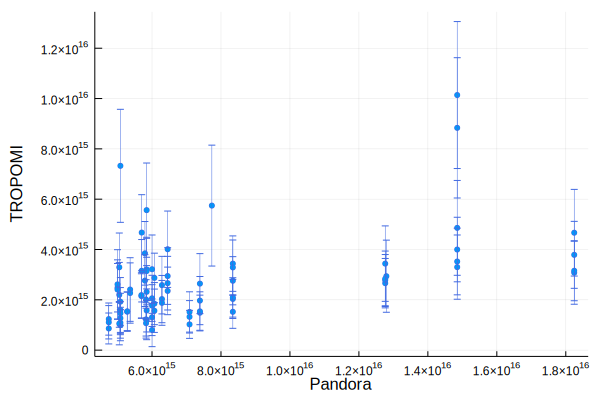

In [45]:
scatter(pandora_no2s, tropomi_no2s, ms=3, markerstrokewidth=0.5, markerstrokecolor=:royalblue, fillalpha=0.5, yerror=tropomi_no2_errs, label="", xlabel="Pandora", ylabel="TROPOMI")

In [50]:
# Dataframe fit
using GLM
df = DataFrame(P = pandora_no2s, T = tropomi_no2s);
lm1 = lm(@formula(P ~ T), df)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

P ~ 1 + T

Coefficients:
──────────────────────────────────────────────────────────────────────────────
               Estimate  Std. Error  t value  Pr(>|t|)   Lower 95%   Upper 95%
──────────────────────────────────────────────────────────────────────────────
(Intercept)  4.88031e15  7.21593e14  6.76325     <1e-8  3.44344e15  6.31718e15
T            1.09021     0.230446    4.73087     <1e-5  0.631335    1.54909   
──────────────────────────────────────────────────────────────────────────────